# The downstream tracking study based on sklearn framework.
## Study of the T-seed selection using BDT classifier

This script contains all of my study based on **BDT - GradientBoostedClassifier**.

## Study roadmap 
--------------
1. Train  the first version of Gradient Boosted Classifer with default parameters and without any features engeenering. Just to know baseline score. 
2. Add basic features transforamtion eg. pseudorapidity and abs. 
3. Tune hiperparameters at first number of trees and learining rate 
4. Add linear combination and features's ratios
5. Speedup the algorithm using idea of [bonsai Decision Trees](http://arxiv.org/pdf/1210.6861v1.pdf)  
   I will use implementation of bBDT from [hep_ml](https://github.com/arogozhnikov/hep_ml/blob/master/hep_ml/speedup.py). 
 


Features descriptions
=================
As mentioned in the [problem description](http://localhost:7000/notebooks/SeedClasifier/Baseline.ipynb#Problem-description) paragraph the Seed classifier take into account only T-Seeds parameters. 
The input T-seeds are stored as a [Event/Track.h](https://lhcb-release-area.web.cern.ch/LHCb-release-area/DOC/rec/latest_doxygen/df/dfc/_track_8h_source.html) data structure. 

T-Seed tagging
-----------
To mark T-Seed as a good track it need to fulfil following criteria: 
1. Has associated MC (Monte Carlo) particle
2. Reconstructable as a downstream track but not as a long track 
    2.1 Has clusters only in the TT and T station
    2.2 No hits in Velo
3. The MC particle is not an electron

See [implementation](https://github.com/adendek/DownstreamTracking/blob/master/BrunelCode/Tr/PatDebugTTTruthTool.cpp#L220). 

Meaning of each T-Seed parameters
---------------

1. seed_chi2PerDof - track's chi^2 per degree of freedom of the track,  
2. seed_p, seed_pt - momentum and transverse momentum of this track,
3. seed_nLHCbIDs - number of hits associated to the T-Seed,
4. seed_niIT -  number of IT hits associated to the T-Seed,
5. seed - number of used T station layers,
6. seed_x, seed_y - x and y coordinate T-Seed projection onto first plate of T-Station
7. seed_tx, seed_ty - x and y coordinate of the T-Seed slope

See [implementation](https://github.com/adendek/DownstreamTracking/blob/master/BrunelCode/Tr/PatDebugTTTruthTool.cpp#L282) of the code responsive for creation of the training NTuple. 


In [3]:
print ("kernel is alive!")

kernel is alive!


In [4]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.externals import joblib

from hep_ml.speedup import LookupClassifier

Welcome to ROOTaaS 6.06/02


### As a very first step I need to grab training data form the NTpule. 
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [6]:
training_file_name = "datasets/Brunel_BdJPsiKs_MagU_30k.root"

In [7]:
root_file = ROOT.TFile(training_file_name)
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(numpy.float64)

target = data.is_downstream_reconstructible

features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27,0,12,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24,0,12,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24,0,12,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24,0,12,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23,0,12,-899.187260,-101.826800,-0.440227,-0.036610


### Print the features distributions

I want to know how doest the features looks like.

In [8]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2415200.000000,2.415200e+06,2415200.000000,2415200.000000,2415200.000000,2415200.000000,2415200.000000,2415200.000000,2415200.000000,2415200.000000
mean,1.871657,2.138872e+04,1730.660542,17.921642,2.797962,11.259784,0.430225,-4.526582,-0.002402,-0.000579
std,1.274678,1.528150e+06,63975.556826,4.672918,4.762586,1.028624,709.552785,522.260590,0.306890,0.067508
min,0.001030,1.121404e+03,2.736860,8.000000,0.000000,8.000000,-2536.044531,-2368.443994,-1.303497,-0.493132
25%,0.983425,3.318111e+03,975.214383,13.000000,0.000000,11.000000,-396.985179,-205.856141,-0.173589,-0.029515
50%,1.494130,6.400423e+03,1153.455988,19.000000,0.000000,12.000000,0.925524,-3.572218,-0.003684,-0.000242
75%,2.391722,1.445767e+04,1406.610291,22.000000,4.000000,12.000000,401.409531,199.154291,0.169162,0.028682
max,8.999642,1.741231e+09,58799206.674761,34.000000,23.000000,12.000000,2511.014943,2224.234014,1.307487,0.426069


In [14]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(features[feature], [1, 99])
        min_value-=0.1*max_value
        max_value+=0.2*max_value
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

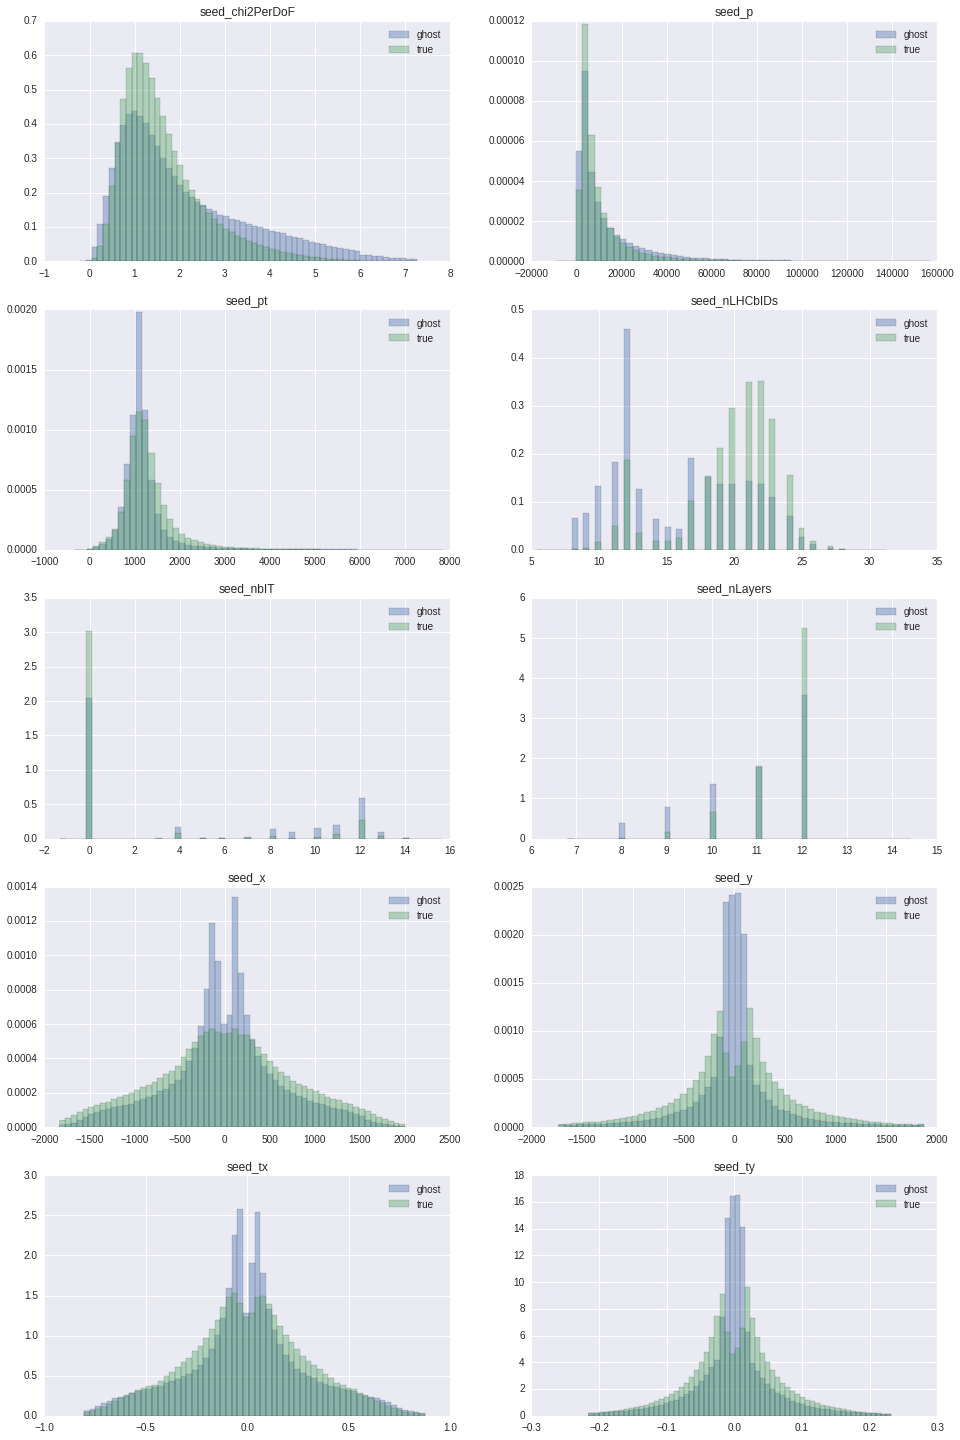

In [15]:
print_features_histograms(features, target)

In [16]:
def pairplot(data, vars):
    sns.pairplot(data, hue="is_true_seed", vars=vars, plot_kws={'alpha': 0.5, 'marker': '.'})


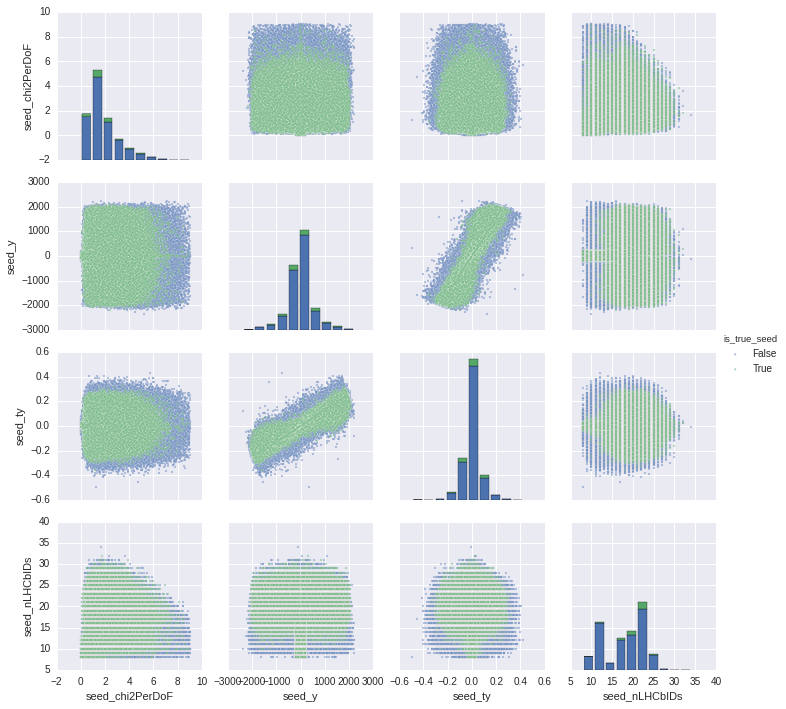

In [18]:
vars = ["seed_chi2PerDoF","seed_y","seed_ty","seed_nLHCbIDs"]
pairplot(data, vars)

## Training of the baseline clasifiers
The aim of this step is to find a BDT score without any tuning of the hyperparameters.   
I use sudo-default set of parameters. I also want to build the tools for further usage. 

Split data into train and validation sets
----------------------

In [19]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

Boosted Decision Tree clasifier
------------------------------
The above plots present's performance of the BDT. It is one of the best classifier, that can be used as a baseline. 

In [20]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8, verbose = 3 )
gb.fit(trainX,trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3104           0.0696           92.86m
         2           1.2550           0.0551           84.54m
         3           1.2082           0.0466           83.32m
         4           1.1715           0.0368           81.56m
         5           1.1375           0.0342           81.45m
         6           1.1070           0.0301           80.89m
         7           1.0808           0.0259           80.50m
         8           1.0541           0.0268           79.92m
         9           1.0335           0.0201           79.58m
        10           1.0151           0.0182           79.11m
        11           0.9958           0.0193           79.18m
        12           0.9814           0.0147           78.84m
        13           0.9635           0.0169           78.77m
        14           0.9491           0.0147           78.38m
        15           0.9384           0.0104           78.19m
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [21]:
print "ROC AUC score"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])

ROC AUC score


0.93754791034250717

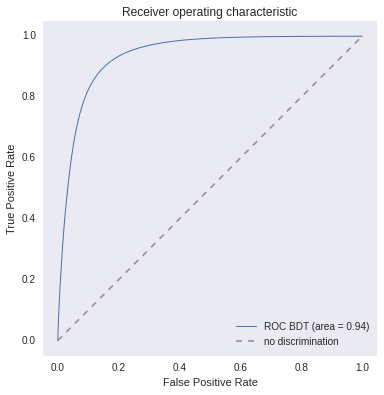

In [22]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Check importance of the features based on the BDT. 

In [23]:
def print_feature_importance(model, features):
    importances = model.feature_importances_
    std = numpy.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = numpy.argsort(importances)[::-1]
    features_names =  list(features.columns.values)

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(features.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, features_names[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(features.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(features.shape[1]), features_names, rotation=70)
    plt.xlim([-1, features.shape[1]])
    plt.show()

Feature ranking:
1. feature seed_chi2PerDoF (0.198387)
2. feature seed_p (0.159979)
3. feature seed_pt (0.141299)
4. feature seed_nLHCbIDs (0.117528)
5. feature seed_nbIT (0.102963)
6. feature seed_nLayers (0.076324)
7. feature seed_x (0.073468)
8. feature seed_y (0.064318)
9. feature seed_tx (0.036848)
10. feature seed_ty (0.028887)


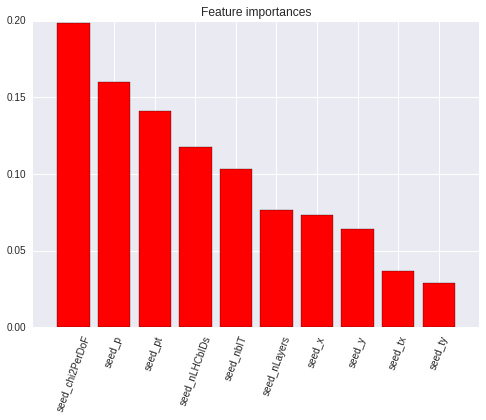

In [24]:
print_feature_importance(gb, features)

In [25]:
probas = gb.staged_predict_proba(testX)
tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(testY, predicted)
    tree_scores.append(score)

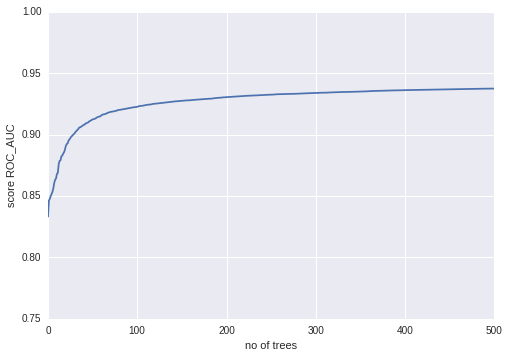

In [26]:
x = numpy.array([x  for x in range(500)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.75, 1)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
import numpy as np
def predict_vs_threshold(probas,threshold):
    probas_df = pd.DataFrame(probas[:, 1])
    predicted = np.where(probas_df>threshold,1,0)
    return predicted

Confusion matrix, without normalization
[[465981  92132]
 [ 58116 591371]]


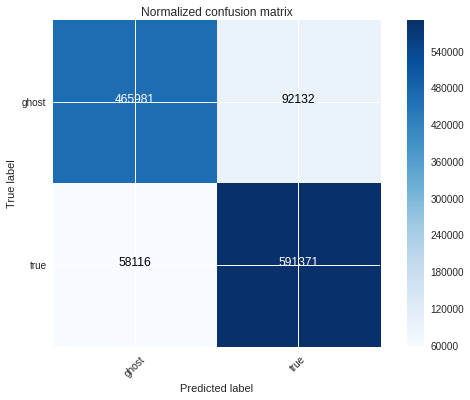

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

   
threshold = 0.5

cnf_matrix = confusion_matrix(testY ,predict_vs_threshold(gb.predict_proba(testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


Normalized confusion matrix
[[ 0.7955862   0.2044138 ]
 [ 0.06330073  0.93669927]]


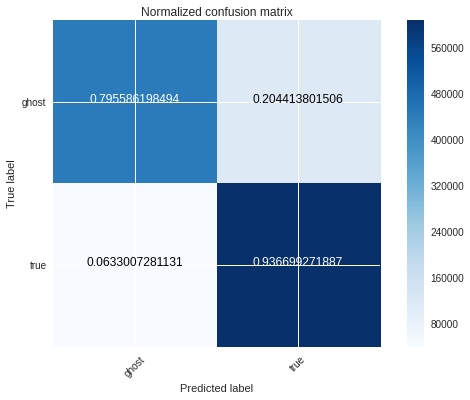

In [30]:
threshold = 0.4

cnf_matrix = confusion_matrix(testY ,predict_vs_threshold(gb.predict_proba(testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, normalize=True, classes=target_names,
                      title='Normalized confusion matrix')

# Feature Engenering

## Add transformated features

At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [31]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [32]:
new_data = basic_transforamtion(data)
new_features =  new_data.drop(["is_true_seed","has_MCParticle",
                    "is_downstream_reconstructible",
                    "has_MCParticle_not_electron",
                    "is_downstream_reconstructible_not_electron",
                    "seed_mva_value",
                    "seed_x",
                    "seed_y",
                    "seed_tx",
                    "seed_ty"] , axis=1).astype(numpy.float64)

new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.447929,1849.101146,1083.522737,27,0,12,1418.736880,143.095899,0.722093,0.038671,1425.935051,0.671511
1,0.354945,10085.622823,1345.148537,24,0,12,393.699553,284.193871,0.129122,0.037920,485.556891,0.134172
2,2.906524,2441.534682,1013.888408,24,0,12,834.004914,270.235334,0.456235,0.015198,876.693408,0.441959
3,3.234916,2604.073941,904.097232,24,0,12,475.119652,230.380918,0.369728,0.018967,528.028457,0.362240
4,0.842265,2644.554049,1068.602364,23,0,12,899.187260,101.826800,0.440227,0.036610,904.934487,0.428511


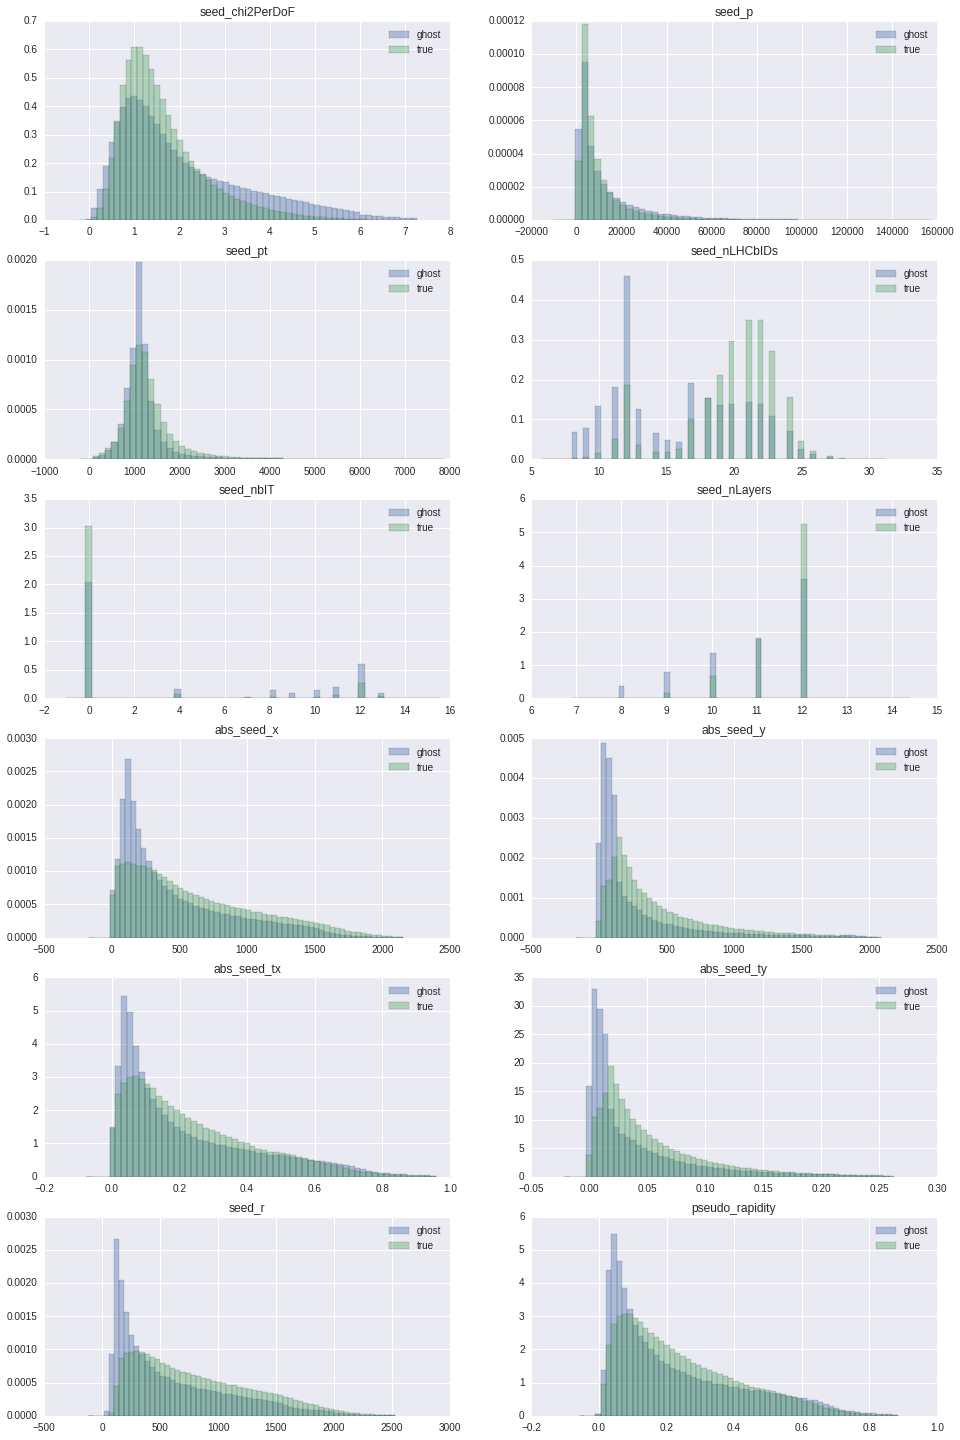

In [33]:
print_features_histograms(new_features, target)

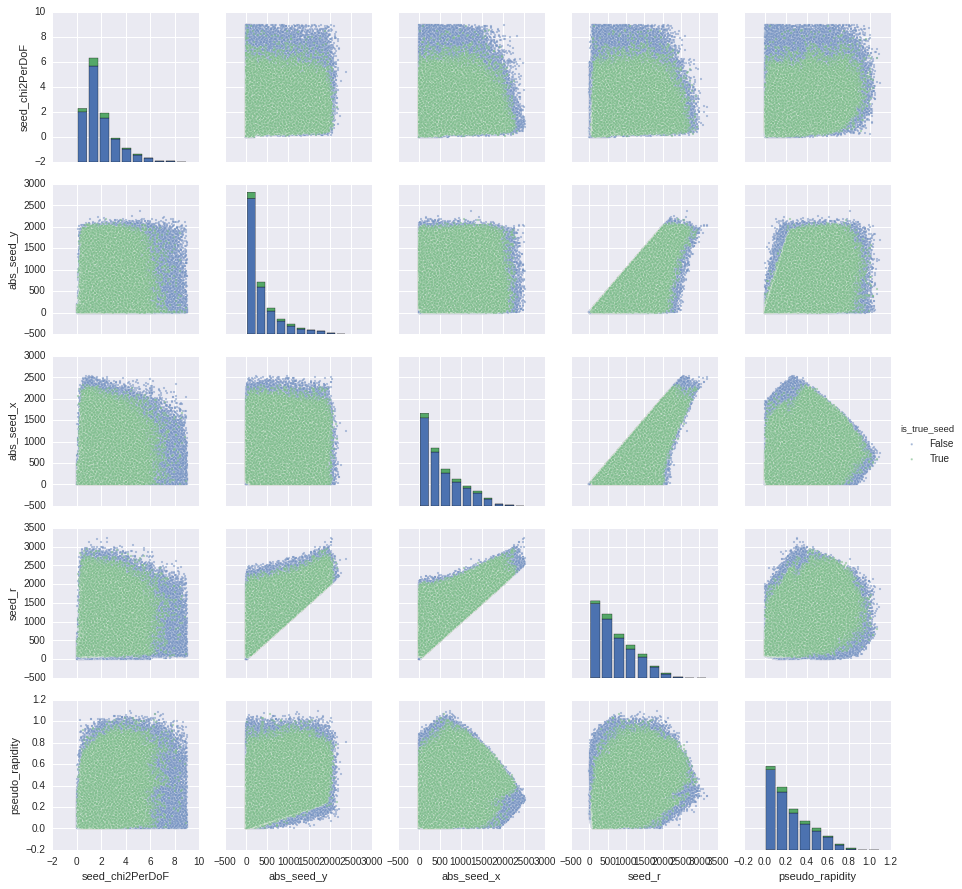

In [34]:
vars = ["seed_chi2PerDoF","abs_seed_y","abs_seed_x","seed_r","pseudo_rapidity"]
pairplot(data, vars)

In [35]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )

In [36]:
gb2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, max_features=8, verbose = 3 )
gb2.fit(new_trainX,new_trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3042           0.0759          124.64m
         2           1.2433           0.0608          116.21m
         3           1.1919           0.0514          112.88m
         4           1.1448           0.0471          112.82m
         5           1.1059           0.0390          112.11m
         6           1.0709           0.0347          111.82m
         7           1.0409           0.0298          110.05m
         8           1.0164           0.0246          108.98m
         9           0.9910           0.0250          107.77m
        10           0.9678           0.0228          106.82m
        11           0.9473           0.0205          106.38m
        12           0.9288           0.0187          106.89m
        13           0.9113           0.0163          106.19m
        14           0.8974           0.0142          105.68m
        15           0.8795           0.0176          105.38m
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=8, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              random_state=13, subsample=0.8, verbose=3, warm_start=False)

In [37]:
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

0.94175017051585908

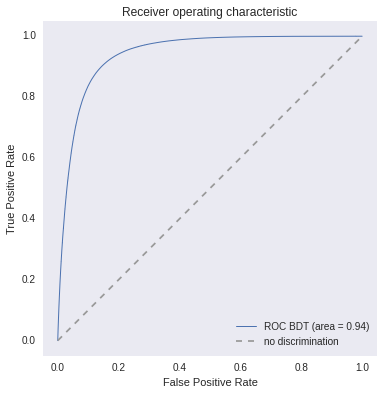

In [38]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Feature ranking:
1. feature seed_chi2PerDoF (0.152129)
2. feature seed_p (0.138813)
3. feature seed_pt (0.135168)
4. feature seed_nLHCbIDs (0.103611)
5. feature seed_nbIT (0.086714)
6. feature seed_nLayers (0.077654)
7. feature abs_seed_x (0.075708)
8. feature abs_seed_y (0.062328)
9. feature abs_seed_tx (0.061046)
10. feature abs_seed_ty (0.058224)
11. feature seed_r (0.027617)
12. feature pseudo_rapidity (0.020989)


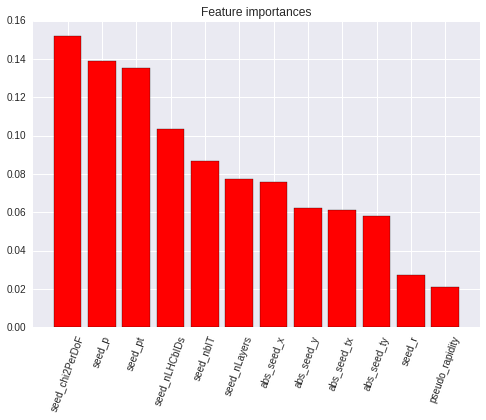

In [39]:
print_feature_importance(gb2, new_features)

In [40]:
probas2 = gb2.staged_predict_proba(new_testX)
tree_scores2 = [] 
for proba in probas2:
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    tree_scores2.append(score)

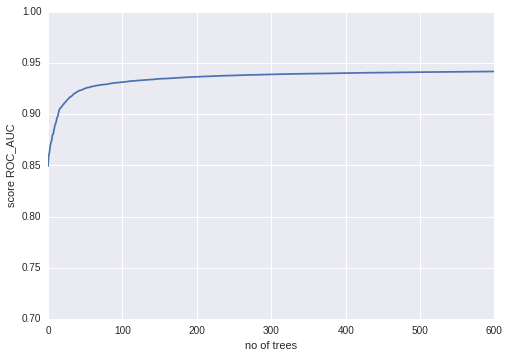

In [43]:
x = numpy.array([x  for x in range(600)])
plt.figure()
plt.plot(x,tree_scores2)
plt.ylim(0.70, 1)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Confusion matrix, without normalization
[[468623  89490]
 [ 54887 594600]]


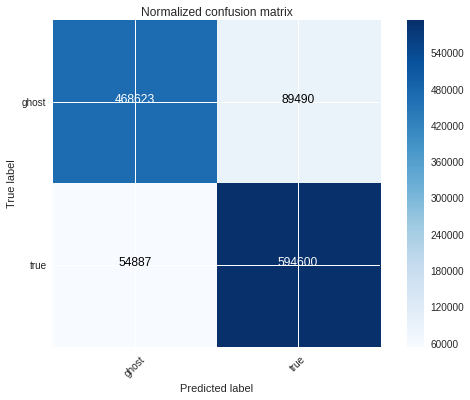

In [44]:
threshold = 0.5

cnf_matrix = confusion_matrix(new_testY ,predict_vs_threshold(gb2.predict_proba(new_testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


Normalized confusion matrix
[[ 0.80322264  0.19677736]
 [ 0.06019828  0.93980172]]


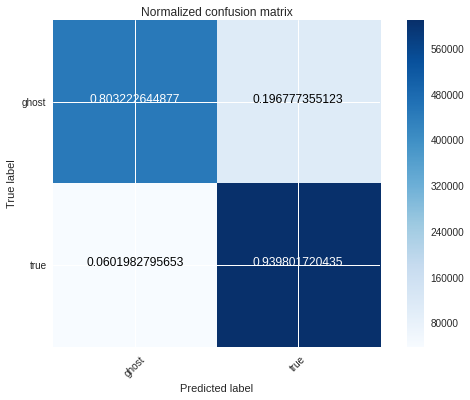

In [45]:
threshold = 0.4

cnf_matrix = confusion_matrix(new_testY ,predict_vs_threshold(gb2.predict_proba(new_testX),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, normalize=True,  classes=target_names,
                      title='Normalized confusion matrix')


## Hyperparameters optimalization

I perform following steps to tune the hyperparameters for a gradient boosting model:

1. Choose loss based on your problem at hand (ie. target metric)
2. Pick n_estimators as large as (computationally) possible (e.g. 600).
3. Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search.
4. Increase n_estimators even more and tune learning_rate again holding the other parameters fixed.
Scikit-learn provides a convenient API for hyperparameter tuning and grid search. 


In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100,150],
              #'max_features': [1.0, 0.3, 0.1] 
              }
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators = 600)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=2,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

In [ ]:
train_gs_X, test_gs_X, train_gs_Y, test_gs_Y = train_test_split(new_features, target, random_state=42,train_size=0.1 )
gb_grid_params = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6, 8],
              'min_samples_leaf': [20, 50,100,150],
              #'max_features': [1.0, 0.3, 0.1] 
              }
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators = 600, max_features=8, subsample=0.8)

clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=2,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(train_gs_X, train_gs_Y);

## Train the new model
I use obtained parameters. 

* n_estimators 600 (wiil be increased depend on learning curve)
* learning rate 0.05
* min sample leaf  100 
* max depth 6

In [ ]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.5 )
gb2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=600, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=8, max_features=8, verbose = 3 )
gb2.fit(new_trainX,new_trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 


In [ ]:
print "ROC AUC score"
roc_auc_score(new_testY, gb2.predict_proba(new_testX)[:, 1])

In [ ]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb2.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Save model to file 
-------
It is a good idea to save BDT parameters to file for further study.  
I use **sklearn.externals.joblib**. According to the documentation is more effitient than pickle. 

In [ ]:
joblib.dump(gb2, 'models/BDT.pkl') 

In [ ]:
probas = gb2.staged_predict_proba(new_testX)
linear_tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(new_testY, predicted)
    linear_tree_scores.append(score)

In [ ]:
x = numpy.array([x  for x in range(600)])
plt.figure()
plt.plot(x,linear_tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Conclusions
--------
I try to add more features I will use as a number of trees = 150 for further study.  
To get the best, final  result I need to use about 400 trees. 

Add linear combination and ratios of the features
-----------

As a very first step I add such features as 
* number of cluster minus number of layers
* divide -||- 
* pseudo rapidity, momentum and transverse momentum divided by chi2 
* number of hit in OT

And then I will try to find importance of it. 

In [36]:
def add_more_transformations(data):
    out = data
    out["seed_lhcbId-layers"] = data.seed_nLHCbIDs - data.seed_nLayers
    out["seed_ot"] = data.seed_nLHCbIDs - data.seed_nbIT
    out["seed_pr/chi2"] = data.pseudo_rapidity / data.seed_chi2PerDoF
    out["seed_p/chi2"] = data.seed_p/ data.seed_chi2PerDoF
    out["seed_tr"]= numpy.sqrt(numpy.square(data.seed_tx) +numpy.square(data.seed_ty))    
    return out

In [40]:
linear_data = add_more_transformations(new_data)
linear_features = linear_data.drop("is_true_seed", axis=1).astype(numpy.float64)
linear_data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,...,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity,seed_lhcbId-layers,seed_pr/chi2,seed_p/chi2,seed_pt/chi2,seed_ot,seed_tr
0,False,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,...,0.524220,0.061572,1364.959300,0.505958,13,0.416870,2095.620933,978.215388,25,0.527823
1,False,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,...,0.480288,0.009081,1268.420312,0.463589,13,0.344391,2066.311262,894.722891,25,0.480374
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,...,0.382802,0.025975,1533.677219,0.374842,13,0.230299,2930.298550,1049.691701,25,0.383682
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,...,0.369674,0.058753,1636.317578,0.366082,13,0.204603,2907.907705,1019.396800,25,0.374314
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,...,0.646627,0.054980,1692.412576,0.610352,12,0.480881,1812.867601,986.879812,24,0.648960


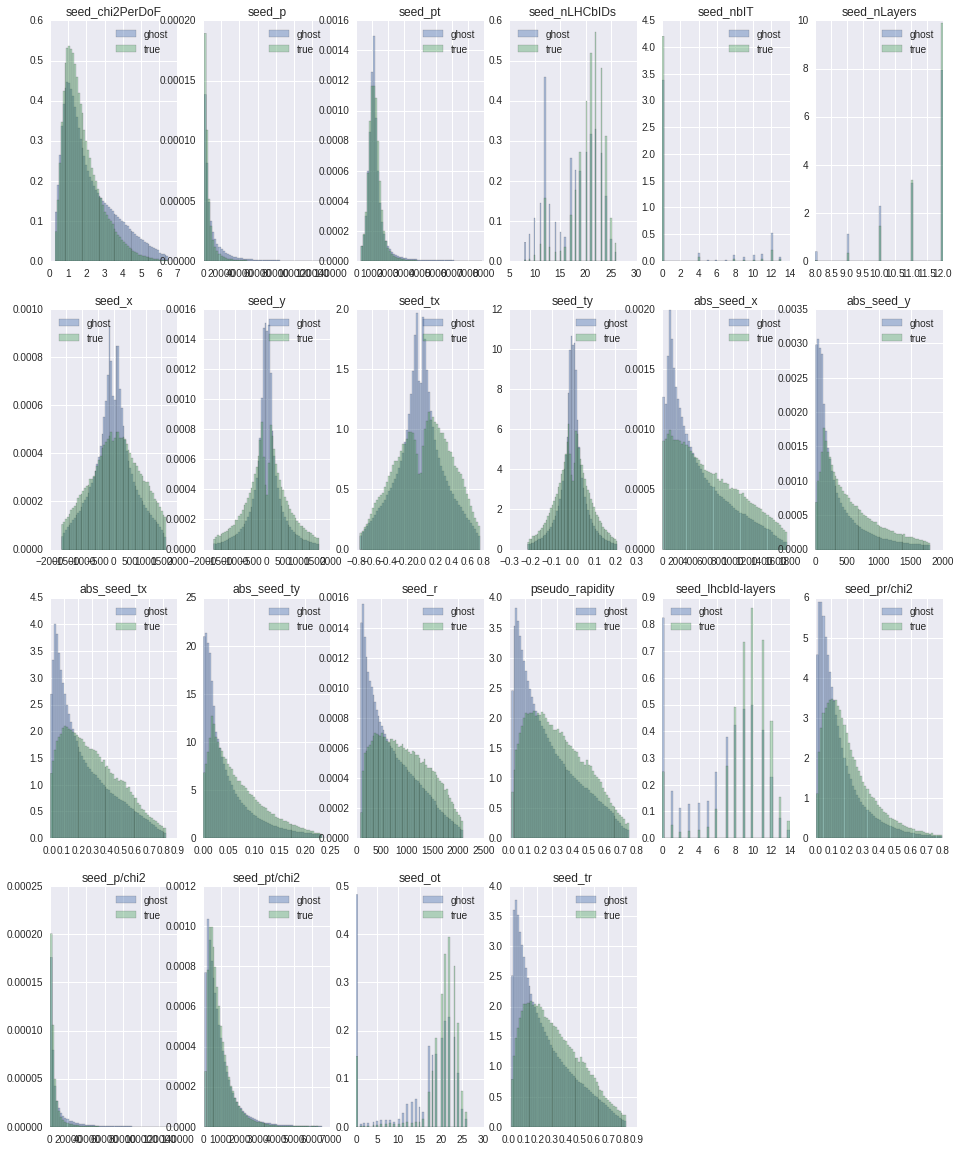

In [41]:
print_features_histograms(linear_features, target)

In [ ]:
linear_trainX, linear_testX, linear_trainY, linear_testY = train_test_split(linear_features, target, random_state=42,train_size=0.5 )
gb_linear= GradientBoostingClassifier(learning_rate=0.2, n_estimators=150, max_depth=6, max_features=8, verbose = 3)
gb_linear.fit(linear_trainX,linear_trainY)
joblib.dump(gb_linear, 'models/BDT_linear.pkl') 

In [25]:
print "ROC AUC score"
roc_auc_score(linear_testY, gb_linear.predict_proba(linear_testX)[:, 1])

ROC AUC score


0.8066236977092156

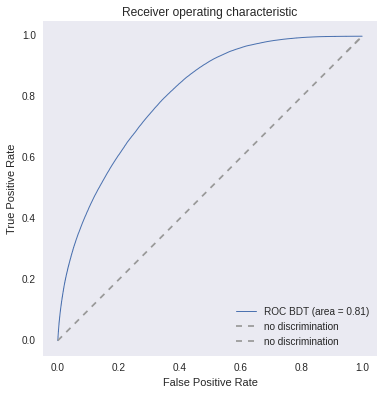

In [26]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(linear_testY, gb_linear.predict_proba(linear_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [29]:
probas = gb_linear.staged_predict_proba(linear_testX)
linear_tree_scores = [] 
for proba in probas:
    predicted = proba[:, 1]
    score =  roc_auc_score(linear_testY, predicted)
    linear_tree_scores.append(score)

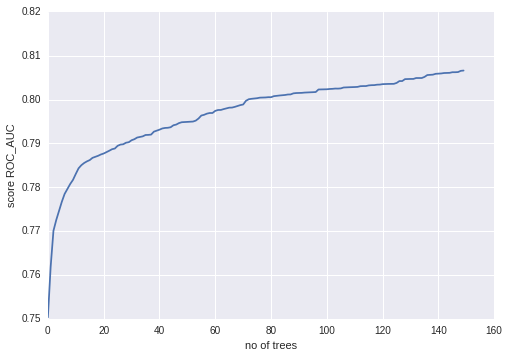

In [31]:
x = numpy.array([x  for x in range(150)])
plt.figure()
plt.plot(x,linear_tree_scores)
plt.ylim(0.75, 0.82)
plt.xlabel('no of trees')
plt.ylabel('score ROC_AUC')
plt.show()

Now you can go to the next model - BDT base on [XGBoost]( [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/BDT-XGBoost.ipynb) or [Logistic Regression](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/LogisticRegression.ipynb)    
=========